# Import 

In [18]:
# 의류 데이터 분류하는 모델 만들어보기 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf # 텐서플로우 import 
import numpy as np
import matplotlib.pyplot as plt


In [19]:
tf.__version__ # 버전 확인

'2.4.0'

# 데이터 불러오기 & 전처리

In [20]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data() # 데이터 불러오기. 튜플로 묶어서 반환

In [21]:
# 데이터 세트의 크기 확인
print(x_train_all.shape, y_train_all.shape) # x_train_all : 28*28 크기를 가진 60000개의 데이터가 있음
# y_train_all : 60000개의 데이터를 가진 1차원 배열. 답이 0~9의 숫자로 들어있음
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠'] # 0~9의 답을 이렇게 표시.

(60000, 28, 28) (60000,)


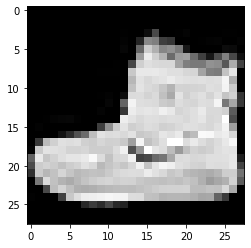

In [22]:
# 샘플 이미지 확인
plt.imshow(x_train_all[0], cmap='gray') # 넘파이 배열을 입력받아 이미지로 표현. cmap(colormap, 색을 표현함. 기본 설정은 viridis(짙은 녹색~밝은 노란색 사이로 표현)이며 따로 값을 줄 수 있음. 이 경우에는 'gray'로 설정)
plt.show()

In [23]:
print(y_train_all[:10]) # 답지 보기. 숫자로 나와있다.

print(class_names[y_train_all[0]]) # 한글로 표시

[9 0 0 3 0 2 7 2 5 5]
앵클부츠


In [24]:
# 타깃 분포 확인(데이터가 균등히 분포 되었는지 확인. 정수값의 등장 횟수 카운트)
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [25]:
# 훈련 세트와 검증 세트로 분류. train_test_split() 사용
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42) # random_state는 안해도 되는데 예제랑 같다는 걸 보여주기 위해 사용한 것. 20%(test_size = 0.2)를 검증 세트로 나눈다.

In [26]:
# 같은 비율로 나눠졌는지 체크
np.bincount(y_train) # 4800개씩 있음
np.bincount(y_val) # 1200개씩 있음 

# 데이터 불러오기 -> 분류 -> 가공하기

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [27]:
# 입력 데이터 정규화. 0~1사이 값으로 나타내기 위해 255로 나눠줌 
x_train = x_train / 255
x_val = x_val / 255

In [28]:
# 28*28를 784(28*28하면 나오는거)로 변경. 왜냐하면 내가 설계한 모델은 1차원 배열을 요구하기 때문.
#한 줄로 쫙 이어붙혔다고 보면 된다.
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1,784)

In [29]:
print(x_train.shape, x_val.shape) # 확인

(48000, 784) (12000, 784)


In [30]:
# 타깃 데이터를 준비하고 다중 분류 신경망 훈련
# 10개의 클래스(상의 등)가 있으니 이에 맞춰 출력값을 가공해야함 -> [1,0,0,0,0...], [0,0,...0,1]와 같이 정답으로 처리한 클래스의 인덱스에 해당하는 값은 1, 나머지는 0인 벡터로 정답 데이터를 가공 -> 원-핫 인코딩(one-hot encoding). 
# 세상에는 참 똑똑한 사람들이 많다
# to_categorical()로 원-핫 인코딩을 수행할 수 있다. 
tf.keras.utils.to_categorical([0,1,3]) # 테스트
# [1., 0., 0., 0.],
# [0., 1., 0., 0.],
# [0., 0., 0., 1.]] 이렇게 나온다. 

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [31]:
# 정답 데이터들을 원-핫 인코딩 처리
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [32]:
print(y_train_encoded.shape, y_val_encoded.shape) # 크기 확인. (48000, )의 1차원에서 (48000, 10)의 2차원 배열로 바뀜

(48000, 10) (12000, 10)


In [33]:
print(y_train[0], y_train_encoded[0]) # 잘 나오는지 체크. 
# 6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]로 나오는데 encoded값을 보면 인덱스가 6에 해당하는 배열에 해당하는 원소가 1이고 나머지는 0인 것을 확인할 수 있다. 

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# 모델 클래스

In [34]:
# 단일 레이어
class SingleLayer:
    def __init__(self, learning_rate = 0.1, l1=0, l2=0):
        self.w = None # 가중치
        self.b = None # 절편
        self.losses = [] # 훈련 데이터에 대한 손실
        self.val_losses = [] # 검증 데이터에 대한 손실
        self.w_history = [] # 가중치 기록
        self.lr = learning_rate # 학습률(내가 따로 지정하는거)
        self.l1 = l1 # L1손실 하이퍼 파라미터
        self.l2 = l2 # L2손실 하이퍼 파라미터

    def forpass(self,x): # 정방향 계산
        z = np.dot(x, self.w) + self.b # 예측값 계산(입력 데이터 * 가중치 + 절편)
        return z

    def backprop(self, x, err): # 역방향 계산
        m = len(x) # 그래디언트 크기. len() : 넘파이 배열의 행 크기 반환.
        w_grad = np.dot(x.T, err) / m # 가중치에 대한 평균 그래디언트
        b_grad = np.sum(err)/m # 절편에 대한 평균 그래디언트
        return w_grad, b_grad
    
    def activation(self, z): # 예측값을 0~1 사이의 값으로 만들어버림.
        a = 1/ (1+ np.exp(-z)) # 시그모이드 계산
        return a

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 행렬 연산을 위해 변환
        y = y.reshape(-1,1) # 열 벡터로 바꿈([ㅁ ㅁ ㅁ ㅁ]^T)
        y_val = y_val.reshape(-1,1) # 열 벡터로 바꿈
        m = len(x)
        #가중치, 절편 초기값 설정
        self.w = np.ones((x.shape[1],1)) # 가중치 초기화([1,1,1]^T)
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록

        # 에포크만큼 반복
        for i in range(epochs):
            z = self.forpass(x) # 예측값 
            a = self.activation(z) # 활성화 함수
            err = -(y-a) #실제 값 - 예측값 = 오차
            #오차를 역전파하여 그래디언트 계산
            w_grad, b_grad = self.backprop(x, err)
            #그래디언트에서 페널티 항의 미분값을 더함
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m # L1규제, L2규제를 적용해 그래디언트 계산
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            #가중치 기록
            self.w_history.append(self.w.copy())
            # 클리핑(역전파 과정에서 그래디언트가 비정상적으로 작아지거나 커지는거 방지)
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss+self.reg_loss())/m) # 평균 손실
            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)

    def predict(self,x):
        z = self.forpass(x)
        return z>0
    
    def score(self, x, y):
        # 예측값, 타깃 값 비교해 True의 비율 반환
        return np.mean(self.predict(x) == y.reshape(-1,1))
    
    def reg_loss(self):
        # 가중치에 규제 적용
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

    # 검증 세트에 대한 손실 계산
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val) # 정방향 계산
        a = self.activation(z) # 활성화 함수
        a = np.clip(a, 1e-10, 1-1e-10) # 활성화 함수 클리핑
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.losses.append((val_loss+self.reg_loss())/ len(y_val)) # 평균 손실

In [35]:
# 단일 레이어를 상속받은 DualLayer
class DualLayer(SingleLayer): # 상속이 안된다. 왜지?

    def __init__(self, units = 10, learning_rate = 0.1, l1 = 0, l2 = 0): # 파이썬은 __init__에서 변수 선언. 항상 신기한 부분이다.
        self.units = units # 은닉층의 뉴런 개수
        # 가중치랑 절편
        self.w1 = None 
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None # 은닉층의 활성화 출력
        self.losses = [] # 훈련 손실
        self.val_losses = [] # 검증 손실
        self.lr = learning_rate # 학습률
        self.l1 = l1 # L1 손실 하이퍼파라미터
        self.l2 = l2 # L2 손실 하이퍼파라미터
    
    def forpass(self, x):# 정방향 계산
        z1 = np.dot(x, self.w1) + self.b1 # 첫 번째 층에서 출력 계산
        self.a1 = self.activation(z1) # 활성화 함수(activation 함수는 SingleLayer에서 가져온 것)
        z2 = np.dot(self.a1, self.w2) + self.b2 # 두 번째 층에서 출력 계산(첫 번째 층의 활성화 함수 출력값 * 두번 째 층의 가중치 + 절편)
        return z2
    
    def backprop(self, x, err): # 역방향 계산
        m = len(x) # 입력 데이터 개수
        
        # 출력층의 가중치, 절편에 대한 공식
        w2_grad = np.dot(self.a1.T, err) / m # 출력층의 가중치에 대한 그래디언트 계산(행렬 연산의 그래디언트 -> Transpose한 행렬과 오차를 계산하면 됨)
        b2_grad = np.sum(err)/m # 절편에 대한 그래디언트
        # 손실 함수(시그모이드 함수)도 그래디언트 계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1) # 은닉층의 그래디언트를 쉽게 계산하기 위해 미리 계산해놓은 것.
        # 은닉충의 가중치와 절편에 대한 그래디언트 계산

        # 첫번 째 층의 그래디언트
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0)/ m

        return w1_grad, b1_grad, w2_grad, b2_grad

    # fit()을 3개로 나눔(init_weights, fit, training)
    # 1. 은닉층, 출력층의 가중치와 절편을 초기화
    # 2. 에포크마다 정방햐 계산
    # 3. 오차를 역전파 가중치, 절편의 그래디언트를 계산
    # 4. 손실을 계산하여 누적
    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units)) # (특성 개수, 은닉층 크기) 만큼의 배열을 생성(모든 원소가 1)
        self.b1 = np.zeros(self.units) # (은닉층 크기, 1) 만큼의 배열 생성
        self.w2 = np.ones((self.units, 1)) # (특성, 1) 크기의 배열 생성
        self.b2 = 0
    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 초기화 파트
        y = y.reshape(-1, 1) # 타깃을 열 벡터(위아래로 긴거)로 바꿈
        y_val = y_val.reshape(-1, 1)
        m = len(x) # 데이터셋 개수
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화
        # 에포크만큼 반복(훈련 파트)
        for i in range(epochs):
            a = self.training(x, y, m) # 정방향, 역방향 계산을 수행. 출력값으로 마지막 활성화 함수의 출력을 반환
            a = np.clip(a, 1e-10, 1-1e-10) # 클리핑. 이렇게 해야 활성화 값이 튀겨서 계산에 지장이 생기는 일을 방지할 수 있다. 
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) # log손실
            self.losses.append((loss + self.reg_loss()) / m) # log손실과 규제 손실(reg_loss)을 더한 걸 리스트에 추가
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)
    # 계산 파트(정방향 계산, 역방향 계산)
    def training(self, x, y, m):
        z = self.forpass(x) # 출력
        a = self.activation(z) # 활성화 함수
        err = -(y-a) # 오차

        #역전파로 그래디언트 계산
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 규제 적용(패널티 항의 미분값 빼기)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

        #은닉층의 가중치, 절편 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        #출력층의 가중치, 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad

        return a
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
            self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2)) # **:나머지








In [36]:
# 가중치의 초기값을 1이 아닌 정규 분포를 따르는 무작위 수로 초기화

class RandomInitNetwork(DualLayer):
    def init_weights(self, n_features): # 가중치, 절편 초기화 함수 재정의
        np.random.seed(42) # 예제에서 이 방식이 통한다는걸 보여주기 위해 랜덤값을 고정시켰으나 실제로는 그럴 필요가 없다. 
        self.w1 = np.random.normal(0, 1, (n_features, self.units)) # normal(평균, 표준편차, 배열 크기). 정규분포에 근거해 난수를 생성
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

# 미니 배치 경사 하강법 적용

In [37]:
# 미니 배치 경사 하강법을 적용한 모델
# 전체 데이터셋을 n등분 후 각 등분된 모델(미니 배치) 단위로 훈련 수행. 확률적 경사 하강법(하나씩 훈련하고 가중치, 절편 반영)과 배치 경사 하강법(전체 다 훈련하고 가중치, 절편 반영)의 중간 단계.
# 그래서 확률적 방식과 배치 방식의 장점, 단점을 모두 가진다. 얼마나 가질지는 미니 배치의 단위(batch_size)로 내가 알아서 조절해야함.( = batch_size는 하이퍼 파라미터)

class MinibatchNetwork(RandomInitNetwork):
    def __init__(self, units = 10, batch_size = 32, learning_rate = 0.1, l1 = 0, l2 = 0):
        super().__init__(units, learning_rate, l1, l2) # 부모 클래스 초기화
        self.batch_size = batch_size
    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 초기화 파트
        y = y.reshape(-1, 1) # 타깃을 열 벡터(위아래로 긴거)로 바꿈
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화
        np.random.seed(42) # 교재에서 예제와 같음을 보여주기 위해 사용한 함수. 실제로는 사용하지 않아도 된다. 

        # 에포크만큼 반복(훈련 파트)
        for i in range(epochs):
            loss = 0
            # 미니 배치를 순환하는 for문
            for x_batch, y_batch in self.gen_batch(x, y): # gen_batch() : 전체 데이터를 받아 batch_size의 크기를 갖는 미니 배치를 만들어 반환
                y_batch = y_batch.reshape(-1,1) # 열 행렬로 변환 
                m = len(x_batch) # 배치 사이즈 크기
                a = self.training(x_batch, y_batch, m) # 미니 배치 단위로 정방향, 역방향 계산을 수행. 출력값으로 마지막 활성화 함수의 출력을 반환
                a = np.clip(a, 1e-10, 1-1e-10) # 클리핑. 이렇게 해야 활성화 값이 튀겨서 계산에 지장이 생기는 일을 방지할 수 있다. 
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a))) # 각 미니배치마다 발생하는 log손실과 규제 손실(reg_loss)을 차곡차곡 쌓음.
            self.losses.append((loss + self.reg_loss()) / len(x)) # 모은 뒤 평균값 구함.
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니 배치가 몇개 있는가? (//연산자는 '몫'을 의미)
        if length % self.batch_size : # 몫으로 나누고 나머지 값이 있으면 
            bins +=1 # 1 추가. 왜냐하면 배치사이즈로 데이터 나누고 남은 값을 버릴 수는 없으니
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞음. x길이만큼 생성된 [0, 1, 2, ...] 배열을 셔플한 걸 반환
        #이 코드를 왜 쓰는거지? ======
        x = x[indexes]
        y = y[indexes]
        #이 코드를 왜 쓰는거지? ======
        for i in range(bins):
            start = self.batch_size*i
            end = self.batch_size*(i+1)
            yield x[start:end], y[start:end] # yield : 반환 방식. 큰 데이터를 한 번만 반환함. 이게 뭔 뜻이냐면 전체 데이터셋 중 index의 범위가 start~end에 해당하는 배열의 일부분을 반환한다는 뜻이다. 이 때 start~end의 범위는 batch_size의 크기와 같다. 매번 포문을 진행할 때마다 batch_size크기에 해당하는 미니 배치들을 처음 데이터부터 마지막 데이터까지 순서대로 뽑아내서 반환하고 이를 이용해 훈련을 시킨다는 거다. 


# 다중 분류 신경망 구현

In [56]:
# MinibatchNetwork에 다중 분류 기능을 추가. 다중 분류의 경사 하강법 알고리즘은 이진 분류의 경사 하강법 알고리즘과 원리는 같고 소프트맥스 함수가 추가된 점만 다르다.
class MultiClassNetwork(MinibatchNetwork):
    # 활성화 함수를 시그모이드 함수로
    def sigmoid(self,z):
        a = 1/(1+np.exp(-z)) # 시그모이드 계산
        return a
    # 소프트맥스 함수
    def softmax(self, z):
        exp_z = np.exp(z) # z(출력값)을 모두 지수로 만들어줌.(z -> e^z)
        return exp_z / np.sum(exp_z, axis = 1).reshape(-1,1) # 소프트맥스 함수는 정규화 함수므로 전체에 대한 비율?인 값으로 반환. 계산을 위해 열 백터로 변환

    def init_weights(self, n_features, n_classes): # 다중 분류 방식이므로 w2의 크기를 (은닉층의 크기, 클래스 개수)로 설정해야한다. 이 때 클래스 개수는 분류할 가짓수 (ex : 자동차, 배, 비행기면 클래스가 3개)의 갯수와 같다.  
        np.random.seed(42) # 예제에서 이 방식이 통한다는걸 보여주기 위해 랜덤값을 고정시켰으나 실제로는 그럴 필요가 없다. 
        self.w1 = np.random.normal(0, 1, (n_features, self.units)) # 정규 분포에 근거한 난수로 (은닉층의 크기, 클래스 개수) 크기의 배열 생성
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))
        self.b2 = np.zeros(n_classes)

    def forpass(self, x):# 정방향 계산. 활성화 함수로 시그모이드 함수를 써야하므로 재정의 한다. 
        z1 = np.dot(x, self.w1) + self.b1 
        self.a1 = self.sigmoid(z1) # 활성화 함수 적용 
        z2 = np.dot(self.a1, self.w2) + self.b2 # 두 번째 층에서 출력 계산(첫 번째 층의 활성화 함수 출력값 * 두번 째 층의 가중치 + 절편)
        return z2

    # fit() 재정의. init_weights()를 호출할 때 클래스의 개수를 매개변수의 값으로 넘겨줌.
    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 초기화 파트
        np.random.seed(42) # 교재에서 예제와 같음을 보여주기 위해 사용한 함수. 실제로는 사용하지 않아도 된다. 
        self.init_weights(x.shape[1], y.shape[1]) # 은닉층과 출력층의 가중치를 초기화

        # 에포크만큼 반복(훈련 파트)
        for i in range(epochs):
            loss = 0
            print('.', end='')# 훈련의 진행 상황을 알아보기 위해 에포크마다 '.'이 출력되게끔 한다. 
            for x_batch, y_batch in self.gen_batch(x, y): # 미니 배치마다 훈련
                a = self.training(x_batch, y_batch)
                # print(a) # 왜 None이라고 뜨지? <- return a를 하지 않았기 때문.
                a = np.clip(a, 1e-10, 1-1e-10) # 클리핑
                loss +=np.sum(-y_batch*np.log(a))# 로그 손실 
            self.losses.append((loss + self.reg_loss()) / len(x)) # 로그 손실 + 규제 손실 더해서 리스트에 추가
            self.update_val_loss(x_val, y_val) # 검증 세트에 대한 손실 계산
    
    # 재정의
    def training(self, x, y):
        m = len(x)
        z = self.forpass(x)
        # print("z : ", z)
        a = self.softmax(z) # 활성화 함수를 softmax()로 변경

        err = -(y-a) # 오차

        #역전파로 그래디언트 계산
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 규제 적용(패널티 항의 미분값 빼기)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

        #은닉층의 가중치, 절편 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        #출력층의 가중치, 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    # predict 함수에서는 결과값만으로 실제값과 비교(=활성화 함수를 거칠 필요가 없음.)
    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis = 1) # 가장 큰 값의 인덱스(=가장 높은 확률로 인식된 것의 인덱스 반환)

    # 예측값과 실제값의 클래스 비교   
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율 반환
        return np.mean(self.predict(x) == np.argmax(y, axis = 1))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.softmax(z)
        a = np.clip(a, 1e-10, 1-1e-10)

        val_loss = np.sum(-y_val * np.log(a)) # 로그 손실
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) # 로그 손실 + 규제 손실을 더해 리스트에 추가

# 훈련하기

In [57]:
fc= MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val = x_val, y_val = y_val_encoded, epochs=40)

........................................

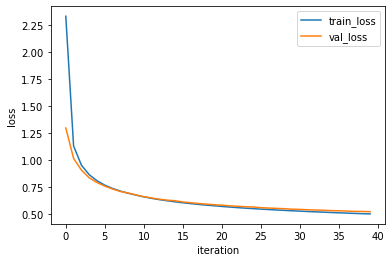

In [58]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 훈련 모델 점수 비교. 초반에 빠르게 감소 -> 수렴.

In [59]:
fc.score(x_val, y_val_encoded) # 점수 확인. 텐서플로우로 만들면 더 정확한 모델을 만들 수 있다.

0.8150833333333334

In [60]:
# 다중 분류를 위한 모델 제작 과정을 정리해보자. 
# 1. 데이터를 전처리 한다. 전체 데이터 세트를 훈련 세트와 테스트 세트로 나누고 훈련 세트를 다시 훈련 세트와 검증 세트로 나눈다. 이 때 다중 분류를 해야하니 답변 데이터(타깃 데이터)를 [0,0,...1,0,..]꼴의 n개의 클래스에 대한 n열 벡터로 만들어주자. 이를 원-핫 인코딩(one-hot encoding)이라고 한다. 
# 2. 모델을 만든다. 이 때 모델에 각 레이어에 대한 가중치가 다 들어있어야 한다.(w1, w2, b1, b2, a1, a2 ,...a). 얘들은 당연히 벡터다. a1, a2, ...는 은닉층의 활성화 함수 값이고 최후의 활성화 함수 출력값(답 결정을 담당하는 값)은 a다. 
# 이 때 당연한 말이지만 역방향 계산으로 각 레이어의 가중치, 절편을 모두 수정해야한다. 
# 초기화(init), 훈련(fit, training), 검증(score)의 3개의 파트로 나눠서 모델을 만들면 된다. 
# 3. 훈련 시키기. 객체 초기화 후 fit()으로 훈련을 시키자. 